In [2]:
#%%
import sys


# Add the path where your Python packages are located
sys.path.append('/home/shij0d/Documents/Dis_Spatial')

import unittest
import torch
from scipy.optimize import minimize
from src.estimation_torch import GPPEstimation  # Assuming your class is defined in gppestimation.py
from src.generation import GPPSampleGenerator
from sklearn.gaussian_process.kernels import Matern
import math
from src.kernel import exponential_kernel,onedif_kernel
from src.networks import generate_connected_erdos_renyi_graph
from src.weights import optimal_weight_matrix
import networkx as nx
import numpy as np
import random
import pickle
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt


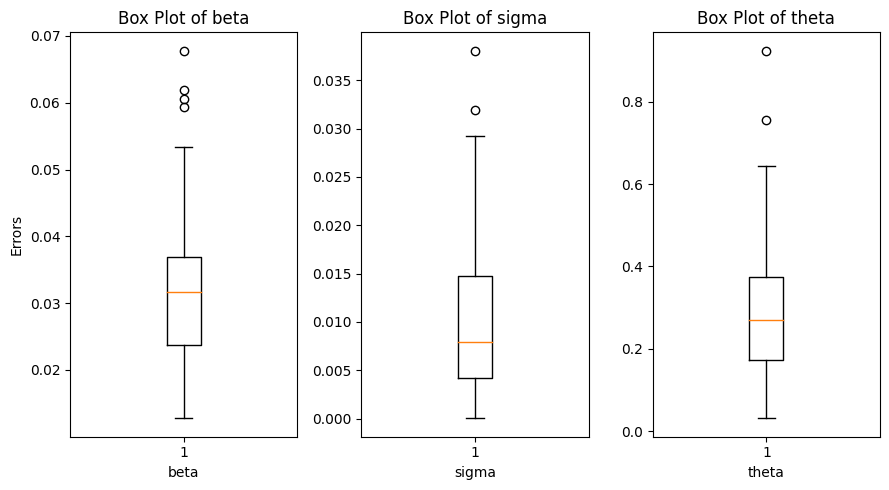

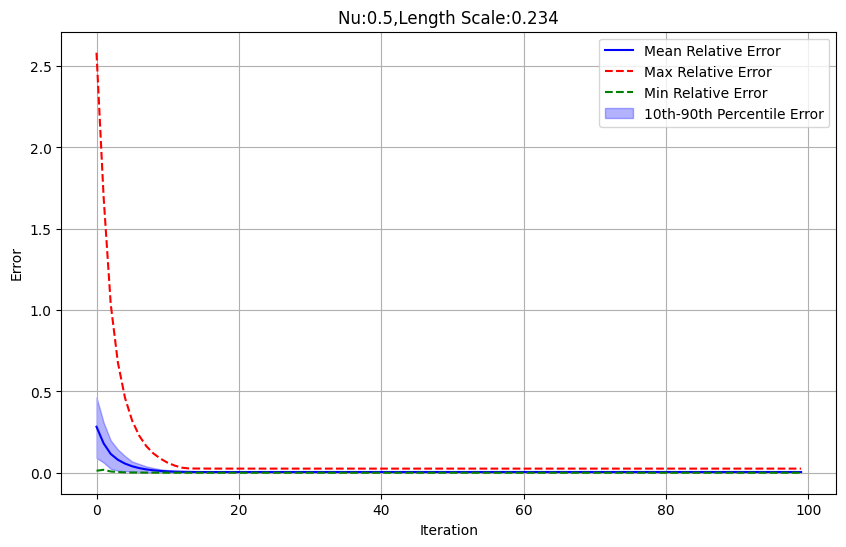

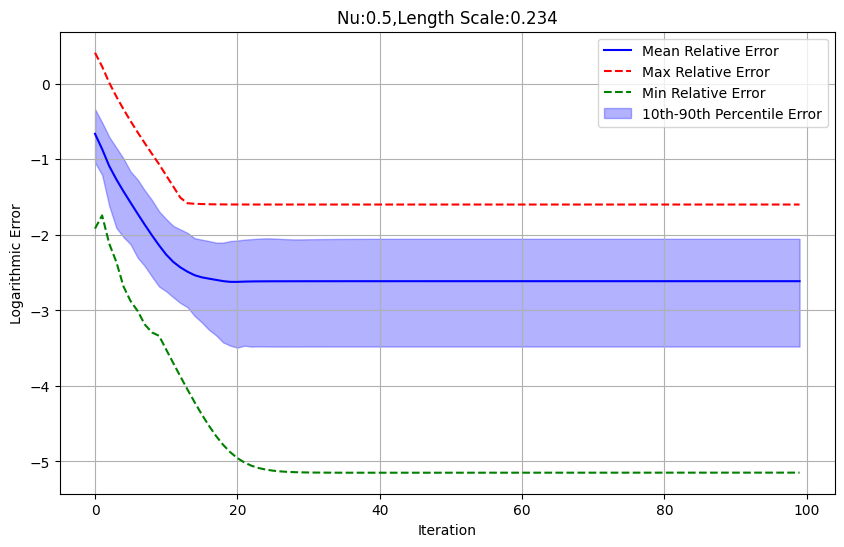

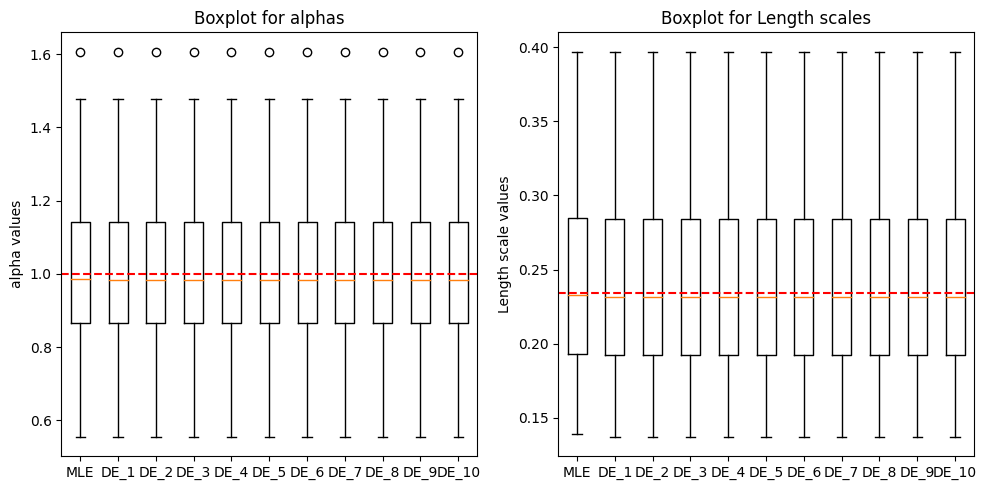

In [5]:
#nu_lengths=[(0.5,0.033),(0.5,0.1),(0.5,0.234),(1.5,0.021),(1.5,0.063),(1.5,0.148)]
nu_lengths=[(0.5,0.234)]
beta=torch.tensor([-1,2,3,-2,1],dtype=torch.float64)
delta=torch.tensor(0.25,dtype=torch.float64)
alpha=1
J=10
for nu_length in nu_lengths:
    nu=nu_length[0]
    length_scale=nu_length[1]
    theta=torch.tensor([alpha,length_scale],dtype=torch.float64)
    with open(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/mindis_0.01/nu_{nu}_length_scale_{length_scale}.pkl', 'rb') as f:
        results=pickle.load(f)
    param_rel_error=np.zeros(shape=(100,100))
    sta_error_beta=np.zeros(shape=(100,))
    sta_error_delta=np.zeros(shape=(100,))
    sta_error_theta=np.zeros(shape=(100,))
    error_rep=[]
    for r in range(100):
        if type(results[r][1])==str:
            error_rep.append(r)
            continue
        sta_error_beta[r]=torch.norm((results[r][1][2].squeeze()-beta)/torch.abs(beta))
        sta_error_delta[r]=torch.norm((results[r][1][3].squeeze()-delta)/torch.abs(delta))
        sta_error_theta[r]=torch.norm((results[r][1][4].squeeze()-theta)/torch.abs(theta))
        for t in range(100):
            rel_error=torch.zeros((J,))
            for j in range(J):
                rel_dif_beta=torch.abs(results[r][0][2][t][j]-results[r][1][2]).squeeze()/torch.abs(beta)
                rel_dif_delta=torch.abs(results[r][0][3][t][j]-results[r][1][3]).squeeze()/torch.abs(delta)
                rel_dif_theta=torch.abs(results[r][0][4][t][j]-results[r][1][4]).squeeze()/torch.abs(theta)
                rel_error[j]=torch.sqrt(torch.square(torch.norm(rel_dif_beta))+torch.square(torch.norm(rel_dif_delta))+torch.square(torch.norm(rel_dif_theta)))
            param_rel_error[r,t]=rel_error.max().numpy()
    #error_rep.append(50)
    param_rel_error=np.delete(param_rel_error,error_rep,axis=0)
    sta_error_beta=np.delete(sta_error_beta,error_rep)
    sta_error_delta=np.delete(sta_error_delta,error_rep)
    sta_error_theta=np.delete(sta_error_theta,error_rep)
    # Calculate the mean, standard deviation, max, and min across replications for each iteration
    
    mean_rel_error= np.mean(param_rel_error, axis=0)
    std_rel_error = np.std(param_rel_error, axis=0)
    percentile_10_error = np.percentile(param_rel_error, 10, axis=0)
    percentile_90_error = np.percentile(param_rel_error, 90, axis=0)
    max_rel_error = np.max(param_rel_error, axis=0)
    min_rel_error = np.min(param_rel_error, axis=0)
    

    #box plot
    fig, axs = plt.subplots(1, 3, figsize=(9, 5))
    axs[0].boxplot(sta_error_beta)
    axs[0].set_title('Box Plot of beta')
    axs[0].set_xlabel('beta')
    axs[0].set_ylabel('Errors')

    # Plot the second box plot for sta_error_delta
    axs[1].boxplot(sta_error_delta)
    axs[1].set_title('Box Plot of sigma')
    axs[1].set_xlabel('sigma')

    # Plot the third box plot for sta_error_theta
    axs[2].boxplot(sta_error_theta)
    axs[2].set_title('Box Plot of theta')
    axs[2].set_xlabel('theta')

    #Adjust layout and display the plots
    plt.tight_layout()
    plt.savefig(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/mindis_0.01/stat_error_nu_{nu}_length_scale_{length_scale}.pdf', dpi=300)
    plt.show()

    # Plot the mean convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rel_error, label='Mean Relative Error', color='blue')

    # Plot the max and min convergence curves
    plt.plot(max_rel_error, label='Max Relative Error', color='red', linestyle='--')
    plt.plot(min_rel_error, label='Min Relative Error', color='green', linestyle='--')

    # Fill between the 25th and 75th percentiles
    plt.fill_between(range(100), percentile_10_error, percentile_90_error, color='blue', alpha=0.3, label='10th-90th Percentile Error')

    # Customize the plot
    plt.title(f'Nu:{nu},Length Scale:{length_scale}')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/mindis_0.01/opt_error_Nu:{nu},length_scale:{length_scale}.pdf', dpi=300)  
    # Show the plot
    plt.show()


    param_rel_error=np.log10(param_rel_error)
    mean_rel_error= np.mean(param_rel_error, axis=0)
    std_rel_error = np.std(param_rel_error, axis=0)
    percentile_10_error = np.percentile(param_rel_error, 10, axis=0)
    percentile_90_error = np.percentile(param_rel_error, 90, axis=0)
    max_rel_error = np.max(param_rel_error, axis=0)
    min_rel_error = np.min(param_rel_error, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rel_error, label='Mean Relative Error', color='blue')

    # Plot the max and min convergence curves
    plt.plot(max_rel_error, label='Max Relative Error', color='red', linestyle='--')
    plt.plot(min_rel_error, label='Min Relative Error', color='green', linestyle='--')

    # Fill between the 25th and 75th percentiles
    plt.fill_between(range(100), percentile_10_error, percentile_90_error, color='blue', alpha=0.3, label='10th-90th Percentile Error')

    # Customize the plot
    plt.title(f'Nu:{nu},Length Scale:{length_scale}')
    plt.xlabel('Iteration')
    plt.ylabel('Logarithmic Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/mindis_0.01/opt_logerror_Nu:{nu},length_scale:{length_scale}.pdf', dpi=300)  
    # Show the plot
    plt.show()

    plt.figure(figsize=(10, 5))

    #box plot for covariance parameter theta
    error_rep=[]
    alphas_de=np.zeros((100,10))
    length_scales_de=np.zeros((100,10))
    alphas_mle=np.zeros((100,))
    length_scales_mle=np.zeros((100,))
    for r in range(100):
        if type(results[r][1])==str:
                error_rep.append(r)
                continue
        alphas_mle[r]=results[r][1][4][0]
        length_scales_mle[r]=results[r][1][4][1]
        for j in range(10): 
            alphas_de[r,j]=results[r][0][4][99][j][0]
            length_scales_de[r,j]=results[r][0][4][99][j][1]
    error_rep.append(50)
    alphas_mle=np.delete(alphas_mle,error_rep)
    length_scales_mle=np.delete(length_scales_mle,error_rep)
    alphas_de=np.delete(alphas_de,error_rep,axis=0)
    length_scales_de=np.delete(length_scales_de,error_rep,axis=0)
    # Box plot for alphas
    plt.subplot(1, 2, 1)
    plt.boxplot([alphas_mle] + [alphas_de[:, j] for j in range(10)], labels=['MLE'] + [f'DE_{j+1}' for j in range(10)])
    plt.axhline(y=alpha, color='r', linestyle='--', label='True Alpha')
    plt.title('Boxplot for alphas')
    plt.ylabel('alpha values')

    # Box plot for length scales
    plt.subplot(1, 2, 2)
    plt.boxplot([length_scales_mle] + [length_scales_de[:, j] for j in range(10)], labels=['MLE'] + [f'DE_{j+1}' for j in range(10)])
    plt.axhline(y=length_scale, color='r', linestyle='--', label='True Length Scale')
    plt.title('Boxplot for Length scales')
    plt.ylabel('Length scale values')

    plt.tight_layout()
    plt.savefig(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/mindis_0.01/boxplot_covpara_Nu:{nu},length_scale:{length_scale}.pdf', dpi=300)
    plt.show()


In [68]:
#box plot for covariance parameter theta
error_rep=[]
alphas_de=np.zeros((100,10))
length_scales_de=np.zeros((100,10))
alphas_mle=np.zeros((100,))
length_scales_mle=np.zeros((100,))
for r in range(100):
    if type(results[r][1])==str:
            error_rep.append(r)
            continue
    alphas_mle[r]=results[r][1][4][0]
    length_scales_mle[r]=results[r][1][4][1]
    for j in range(10): 
        alphas_de[r,j]=results[r][0][4][99][j][0]
        length_scales_de[r,j]=results[r][0][4][99][j][1]

alphas_mle=np.delete(alphas_mle,error_rep)
length_scales_mle=np.delete(length_scales_mle,error_rep)
alphas_de=np.delete(alphas_de,error_rep,axis=0)
length_scales_de=np.delete(length_scales_de,error_rep,axis=0)

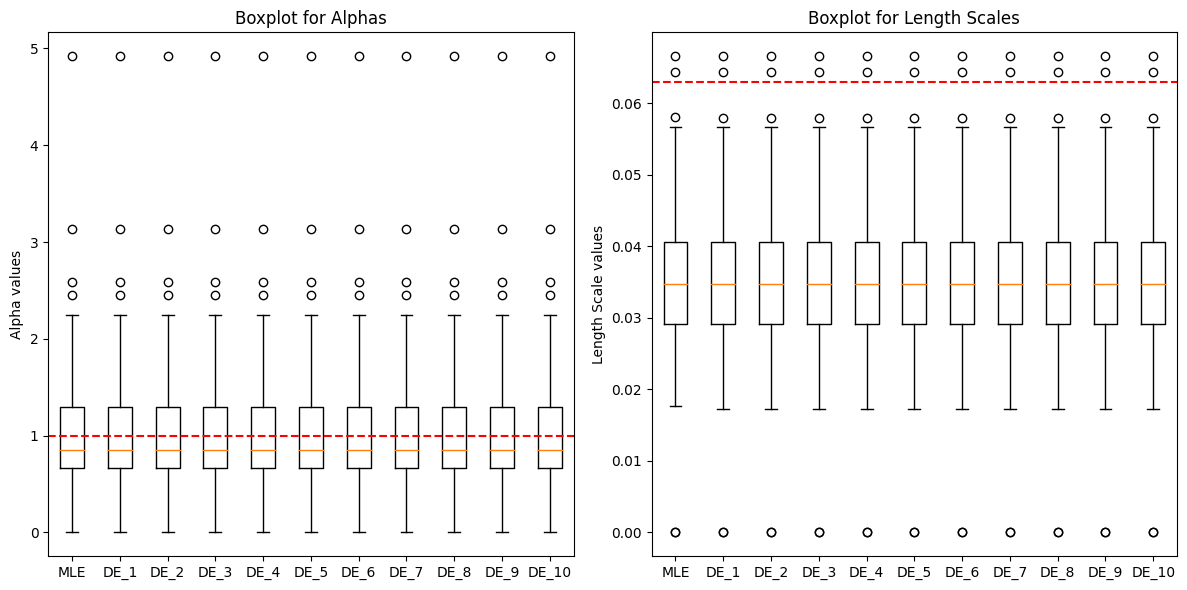

In [81]:
plt.figure(figsize=(12, 6))

# Box plot for alphas
plt.subplot(1, 2, 1)
plt.boxplot([alphas_mle] + [alphas_de[:, j] for j in range(10)], labels=['MLE'] + [f'DE_{j+1}' for j in range(10)])
plt.axhline(y=alpha, color='r', linestyle='--', label='True Alpha')
plt.title('Boxplot for Alphas')
plt.ylabel('Alpha values')

# Box plot for length scales
plt.subplot(1, 2, 2)
plt.boxplot([length_scales_mle] + [length_scales_de[:, j] for j in range(10)], labels=['MLE'] + [f'DE_{j+1}' for j in range(10)])
plt.axhline(y=length_scale, color='r', linestyle='--', label='True Length Scale')
plt.title('Boxplot for Length Scales')
plt.ylabel('Length Scale values')

plt.tight_layout()
plt.show()

In [51]:
results[98]

(98, 'distributed minimization error')

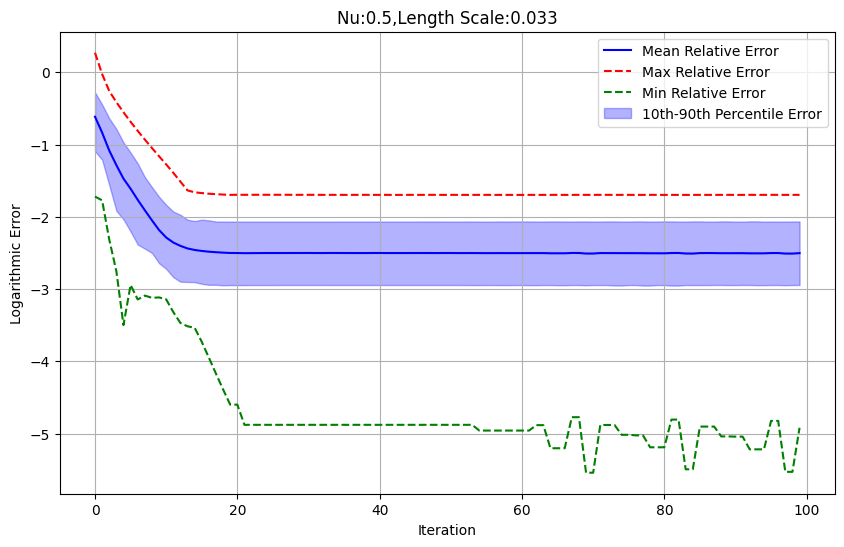

In [103]:
mean_rel_error= np.mean(param_rel_error, axis=0)
std_rel_error = np.std(param_rel_error, axis=0)
percentile_10_error = np.percentile(param_rel_error, 10, axis=0)
percentile_90_error = np.percentile(param_rel_error, 90, axis=0)
max_rel_error = np.max(param_rel_error, axis=0)
min_rel_error = np.min(param_rel_error, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(mean_rel_error, label='Mean Relative Error', color='blue')

    # Plot the max and min convergence curves
plt.plot(max_rel_error, label='Max Relative Error', color='red', linestyle='--')
plt.plot(min_rel_error, label='Min Relative Error', color='green', linestyle='--')

    # Fill between the 25th and 75th percentiles
plt.fill_between(range(100), percentile_10_error, percentile_90_error, color='blue', alpha=0.3, label='10th-90th Percentile Error')

    # Customize the plot
plt.title(f'Nu:{nu},Length Scale:{length_scale}')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic Error')
plt.legend()
plt.grid(True)
plt.savefig(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/opt_logerror_Nu:{nu},length_scale:{length_scale}.pdf', dpi=300)  
    # Show the plot
plt.show()

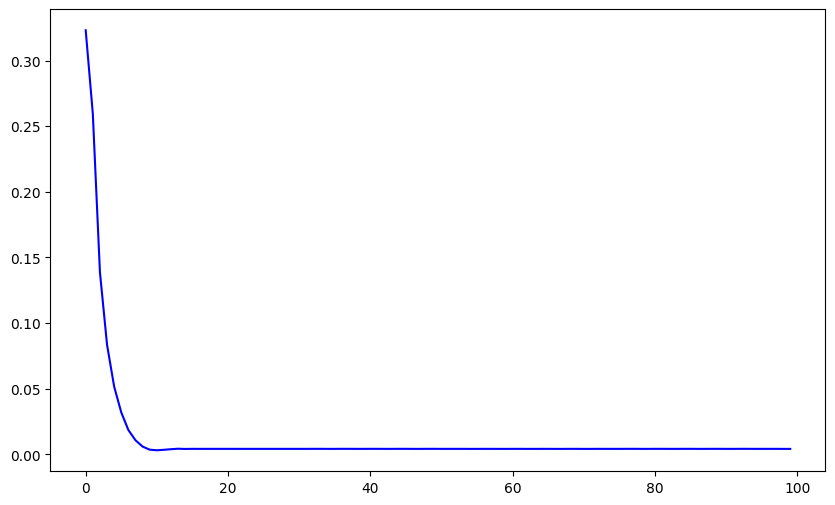

In [57]:
nu_length=nu_lengths[0]
nu=nu_length[0]
length_scale=nu_length[1]
theta=torch.tensor([alpha,length_scale],dtype=torch.float64)
with open(f'/home/shij0d/Documents/Dis_Spatial/expriements/decentralized/varying_parameter/nu_{nu}_length_scale_{length_scale}.pkl', 'rb') as f:
        results=pickle.load(f)
param_rel_error=np.zeros(shape=(100,100))
for r in range(100):
        for t in range(100):
            rel_error=torch.zeros((J,))
            for j in range(J):
                rel_dif_beta=torch.abs(results[r][0][2][t][j]-results[r][1][2]).squeeze()/torch.abs(beta)
                rel_dif_delta=torch.abs(results[r][0][3][t][j]-results[r][1][3]).squeeze()/torch.abs(delta)
                rel_dif_theta=torch.abs(results[r][0][4][t][j]-results[r][1][4]).squeeze()/torch.abs(theta)
                rel_error[j]=torch.sqrt(torch.square(torch.norm(rel_dif_beta))+torch.square(torch.norm(rel_dif_delta))+torch.square(torch.norm(rel_dif_theta)))
            param_rel_error[r,t]=rel_error.max().numpy()


In [88]:
param_rel_error=10**param_rel_error

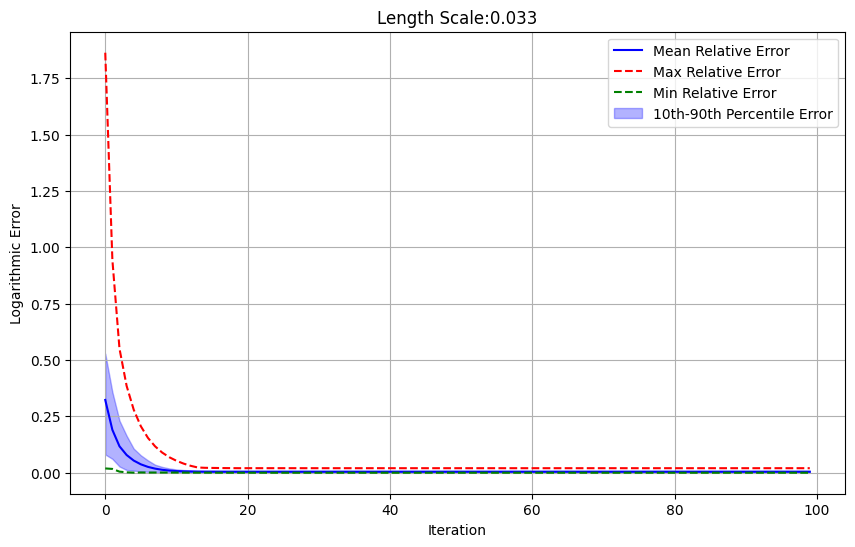

In [90]:
mean_rel_error= np.mean(param_rel_error, axis=0)
std_rel_error = np.std(param_rel_error, axis=0)
percentile_10_error = np.percentile(param_rel_error, 10, axis=0)
percentile_90_error = np.percentile(param_rel_error, 90, axis=0)
max_rel_error = np.max(param_rel_error, axis=0)
min_rel_error = np.min(param_rel_error, axis=0)
    

    # Plot the mean convergence curve
plt.figure(figsize=(10, 6))
plt.plot(mean_rel_error, label='Mean Relative Error', color='blue')

    # Plot the max and min convergence curves
plt.plot(max_rel_error, label='Max Relative Error', color='red', linestyle='--')
plt.plot(min_rel_error, label='Min Relative Error', color='green', linestyle='--')

    # Fill between the 25th and 75th percentiles
plt.fill_between(range(100), percentile_10_error, percentile_90_error, color='blue', alpha=0.3, label='10th-90th Percentile Error')

    # Customize the plot
plt.title(f'Length Scale:{length_scale}')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic Error')
plt.legend()
plt.grid(True)
plt.savefig(f'exp1_length_scale:{length_scale}.pdf', dpi=300)  
    # Show the plot
plt.show()

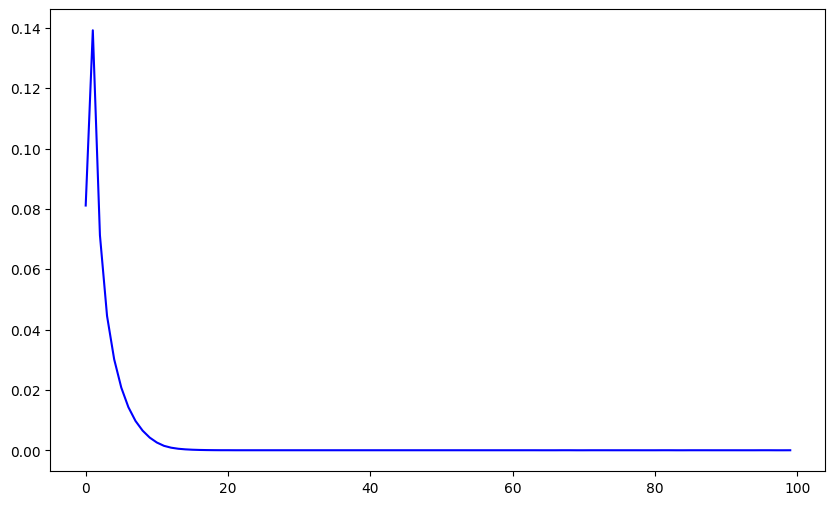

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(param_rel_error[14,:], label='Relative Error', color='blue')

In [82]:
np.argmin(param_rel_error[:,99])

14

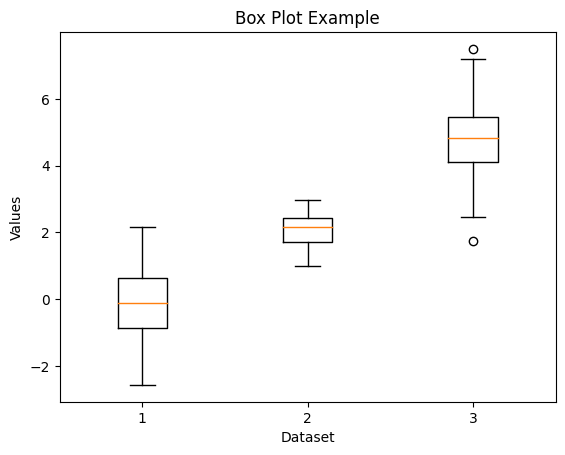

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [np.random.normal(0, 1, 100), np.random.normal(2, 0.5, 100), np.random.normal(5, 1, 100)]

# Create a box plot
plt.boxplot(data)

# Add title and labels
plt.title('Box Plot Example')
plt.xlabel('Dataset')
plt.ylabel('Values')

# Show plot
plt.show()
